In [48]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import polars as pl
import datetime
import numpy as np
from math import sqrt
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
import shap

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

import plotly.io as pio

# development
# pio.renderers.default = 'vscode'

# web export
pio.renderers.default = 'jpg'

/home/ola/Projekty/shipment-volume-forecasting/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



# Model dla klientów innych niż X

In [18]:
df_customers = pl.read_parquet("/home/ola/Projekty/shipment-volume-forecasting/output/df_customers_no_x.parquet")

Aby zachować informacje o zmiennych o charakterze dziennym zdecydowałam się na stworzenie modelu dziennego i późniejszą agregację wyników do postaci tygodniowej. 

In [19]:
df_customers = df_customers.sort(["Date", "Customer"])
df_customers = df_customers.with_columns(pl.col("Customer").alias("CustomerOriginal"))
df_customers = df_customers.with_columns(
    pl.col("week_start").alias("dateWeekStart")
)
cat_cols = ["Customer", "Product", "CollectionCountry", "DeliveryCountry"]

df_all_encoded = df_customers.to_dummies(columns=cat_cols)

In [20]:
columns_to_drop = [
    "week_start",
    "is_customer_x",
    "Predictions_X",
    "firstDayNoSaturdayNoHolidayOrSundayHoliday",
    "dateMonthNamePL",
    "dateWeekOfYearStartsMonday",
    "dateWeekDayStartsMonday",
    "dateWeekDayNamePL",
    "dateQuarterName",
    "dateWeekOfYearISO",
    "dateWeekDayName",
    "dateDaySuffix",
    "dateWeekDayNameShort",
    "datePk",
    "dateYear",
    "dateYearISO",
    "dateMonthYear",
    "dateWeekYearISO",
    "dateQuarterYear",
    "dateWeekDayNameFirstLetter",
    "dateMonthName",
    "dateMonthNameShort",
    "dateMonthNameFirstLetter",
    "dateQuarterShort",
    "firstDayWorkBefore",
    "firstDayWorkAfter",
    "firstDayNoHolidayNoSaturdayAfter",
    "firstDayNoHolidayNoSundayAfter",
    "firstDayNoHolidayNoSaturdayAfterData",
    "firstDayNoSaturdayNoHolidayOrSundayHolidayName",
]

df_all_encoded = df_all_encoded.drop(columns_to_drop)

In [21]:

def rolling_time_splits(
    df: pl.DataFrame,
    date_col: str,
    cutoff_dates: list[datetime.date],
    forecast_horizon: int,
):

    splits = []
    for cutoff in cutoff_dates:
        train_df = df.filter(pl.col(date_col) <= cutoff)

        test_end = cutoff + datetime.timedelta(days=forecast_horizon)
        test_df = df.filter(
            (pl.col(date_col) > cutoff) & (pl.col(date_col) <= test_end)
        )

        if len(train_df) > 0 and len(test_df) > 0:
            splits.append((train_df, test_df))
    return splits

In [22]:

cutoff_dates = [
    datetime.date(2023, 6, 30),
    datetime.date(2023, 7, 31),
    datetime.date(2023, 8, 31),
    datetime.date(2023, 9, 30),
]
forecast_horizon = 90

folds = rolling_time_splits(
    df=df_all_encoded,
    date_col="Date",
    cutoff_dates=cutoff_dates,
    forecast_horizon=forecast_horizon,
)



In [23]:
def rolling_cv_score(params, folds, feature_cols):
    fold_errors = []


    for i, (train_df, test_df) in  enumerate(folds, start=1):

        X_train = train_df.select(feature_cols).to_pandas()
        y_train = train_df["Volume"].to_pandas()

        X_test = test_df.select(feature_cols).to_pandas()
        y_test = test_df["Volume"].to_pandas()

        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train)

        preds = model.predict(X_test)

        mae = mean_absolute_error(y_test, preds)
        rmse = sqrt(np.mean((y_test - preds) ** 2))
        fold_errors.append(rmse)
        
    return np.mean(fold_errors)

In [24]:
all_cols = df_all_encoded.columns
feature_cols = [col for col in all_cols if col not in ("Date", "Volume", "CustomerOriginal", "dateWeekStart")]


search_space = [
    Integer(low=3,  high=9,   name='max_depth'),
    Real(low=0.01,  high=0.2, prior='log-uniform', name='learning_rate'),
    Integer(low=50, high=300, name='n_estimators'),
    Real(low=0.5,   high=1.0, name='subsample'),
]

@use_named_args(search_space)
def objective(**params):

    params["random_state"] = 42
    params["tree_method"]='hist'
    params["device"]='cuda'
    
    score = rolling_cv_score(params, folds, feature_cols)
    return score

res = gp_minimize(
    func=objective,
    dimensions=search_space,
    n_calls=10,            
    n_initial_points=3,     
    random_state=42
)
print("Best score (RMSE):", res.fun)
print("Best param values:", res.x)

best_params_dict = {
    "max_depth": res.x[0],
    "learning_rate": res.x[1],
    "n_estimators": res.x[2],
    "subsample": res.x[3],
    "random_state": 42
}
print("Best Params (dict):", best_params_dict)

final_rmse = rolling_cv_score(best_params_dict, folds, feature_cols)
print(f"Final average RMSE across folds with best params: {final_rmse:.3f}")


Best score (RMSE): 1280.5272377636538
Best param values: [np.int64(8), 0.0533530257056547, np.int64(244), 0.8040609539491996]
Best Params (dict): {'max_depth': np.int64(8), 'learning_rate': 0.0533530257056547, 'n_estimators': np.int64(244), 'subsample': 0.8040609539491996, 'random_state': 42}
Final average RMSE across folds with best params: 1294.412


In [25]:
results = []
predictions_list = []
for i, (train_df, test_df) in enumerate(folds, start=1):

        X_train = train_df.select(feature_cols).to_pandas()
        y_train = train_df["Volume"].to_pandas()

        X_test = test_df.select(feature_cols).to_pandas()
        y_test = test_df["Volume"].to_pandas()

        model = xgb.XGBRegressor(**best_params_dict)
        model.fit(X_train, y_train)

        preds = model.predict(X_test)

        mae = mean_absolute_error(y_test, preds)
        rmse = sqrt(np.mean((y_test - preds) ** 2))
        results.append(
        {
            "fold": i,
            "cutoff_date": cutoff_dates[i - 1],
            "test_start": cutoff_dates[i - 1] + datetime.timedelta(days=1),
            "test_end": cutoff_dates[i - 1] + datetime.timedelta(days=forecast_horizon),
            "MAE": mae,
            "RMSE": rmse,
        }
    )


        test_df_pd = test_df.to_pandas()
        test_df_pd["Prediction"] = preds
        test_df_pd["Customer"] = test_df["CustomerOriginal"].to_pandas()
        test_df_pd["cutoff_date"] = cutoff_dates[i - 1]
        predictions_list.append(test_df_pd[["Date", "CustomerOriginal", "Volume", "Prediction", "dateWeekStart", "cutoff_date"]])


df_predictions = pd.concat(predictions_list, ignore_index=True)
df_results = pd.DataFrame(results)
print(df_results)
print("Average RMSE:", df_results["RMSE"].mean())



   fold cutoff_date  test_start    test_end         MAE         RMSE
0     1  2023-06-30  2023-07-01  2023-09-28  663.496277  1044.045310
1     2  2023-07-31  2023-08-01  2023-10-29  669.597839  1044.964583
2     3  2023-08-31  2023-09-01  2023-11-29  763.561890  1317.069841
3     4  2023-09-30  2023-10-01  2023-12-29  995.134338  1771.569444
Average RMSE: 1294.4122945626596


In [26]:

df_weekly = (
    pl.from_pandas(df_predictions)
    .with_columns(
        pl.col("Volume").sum().over(["dateWeekStart", "CustomerOriginal"]).alias("ActualWeeklyVolume"),
        pl.col("Prediction").sum().over(["dateWeekStart", "CustomerOriginal"]).alias("PredictedWeeklyVolume"),
    )
    .with_columns(
        (pl.col("ActualWeeklyVolume") - pl.col("PredictedWeeklyVolume")).alias("Error")
    )
    .sort(["CustomerOriginal", "dateWeekStart"])
)

errors_weekly_cutoffs = (
    df_weekly.with_columns(
        (pl.col("Error").abs().mean().over("cutoff_date")).alias("MAE"),
        np.sqrt((pl.col("Error") ** 2).mean().over("cutoff_date")).alias("RMSE"),
    )
    .select("cutoff_date", "MAE", "RMSE")
    .unique()
    .sort("cutoff_date")
)

errors_weekly_cutoffs

cutoff_date,MAE,RMSE
date,f64,f64
2023-06-30,6558.436343,11375.752909
2023-07-31,9055.927782,14464.467623
2023-08-31,10934.703744,18973.514363
2023-09-30,10924.392832,19096.924285


In [27]:
overall_rmse = root_mean_squared_error(
    df_weekly.select(pl.col("ActualWeeklyVolume")),
    df_weekly.select(pl.col("PredictedWeeklyVolume")),
)
overall_mae = mean_absolute_error(
    df_weekly.select(pl.col("ActualWeeklyVolume")),
    df_weekly.select(pl.col("PredictedWeeklyVolume")),
)

print(f"Overall Weekly RMSE: {overall_rmse}, MAE: {overall_mae}")

Overall Weekly RMSE: 16324.609347947175, MAE: 9379.741827485595


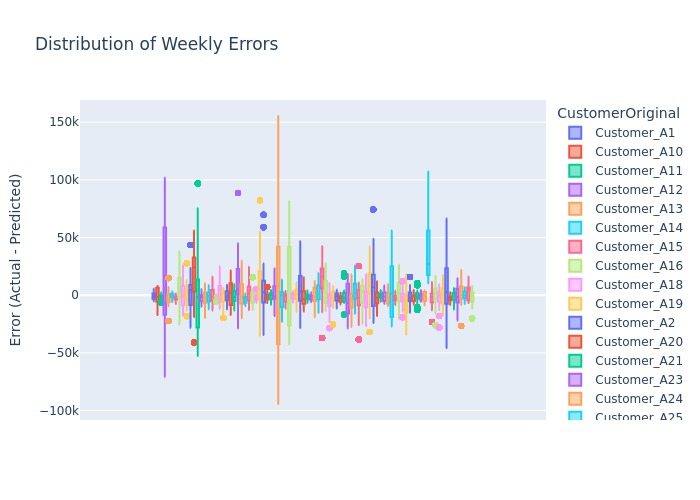

In [28]:
fig_box = px.box(
    df_weekly,
    y="Error",
    color="CustomerOriginal",
    title="Distribution of Weekly Errors"
)
fig_box.update_layout(yaxis_title="Error (Actual - Predicted)")

pio.show(fig_box)

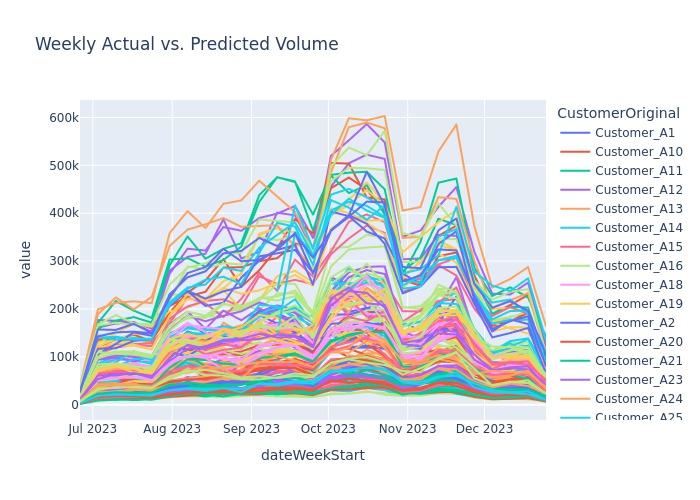

In [29]:


fig = px.line(df_weekly, x="dateWeekStart", y=["ActualWeeklyVolume", "PredictedWeeklyVolume"], color="CustomerOriginal",
    title="Weekly Actual vs. Predicted Volume"
)
pio.show(fig)

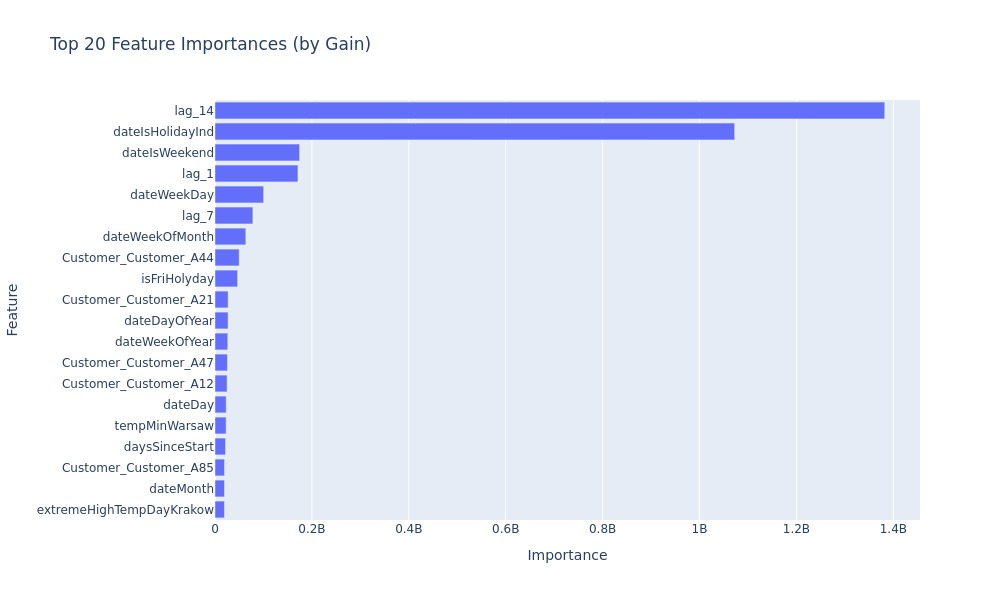

In [30]:
importance_dict = model.get_booster().get_score(importance_type="gain")

sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

top_n = 20
top_features = sorted_importance[:top_n]

df_imp = pd.DataFrame(top_features, columns=["Feature", "Importance"])

fig_feat = px.bar(
    df_imp,
    width=1000, height=600,
    x="Importance",
    y="Feature",
    orientation='h',
    title=f"Top {top_n} Feature Importances (by Gain)"
)

fig_feat.update_yaxes(autorange="reversed")
fig_feat.update_layout(xaxis_title="Importance", yaxis_title="Feature")
pio.show(fig_feat)

In [31]:
importance_dict = model.get_booster().get_score(importance_type="gain")
print(importance_dict)

{'Customer_Customer_A1': 7563177.0, 'Customer_Customer_A10': 6936730.0, 'Customer_Customer_A11': 6780005.0, 'Customer_Customer_A12': 24945828.0, 'Customer_Customer_A13': 153702.671875, 'Customer_Customer_A14': 13920.6669921875, 'Customer_Customer_A15': 10017904.0, 'Customer_Customer_A16': 7166050.0, 'Customer_Customer_A18': 4941925.0, 'Customer_Customer_A19': 4598628.0, 'Customer_Customer_A2': 12219598.0, 'Customer_Customer_A20': 14423990.0, 'Customer_Customer_A21': 27073548.0, 'Customer_Customer_A23': 8330827.0, 'Customer_Customer_A24': 1444605.375, 'Customer_Customer_A25': 14158668.0, 'Customer_Customer_A26': 9934188.0, 'Customer_Customer_A28': 12137348.0, 'Customer_Customer_A29': 4235466.5, 'Customer_Customer_A3': 6773574.0, 'Customer_Customer_A30': 9593848.0, 'Customer_Customer_A33': 14775754.0, 'Customer_Customer_A34': 8689247.0, 'Customer_Customer_A35': 6008971.5, 'Customer_Customer_A36': 13592699.0, 'Customer_Customer_A38': 572781.375, 'Customer_Customer_A39': 847272.625, 'Custo

# Model dla klienta X


In [33]:
df_customer_x = pl.read_parquet("/home/ola/Projekty/shipment-volume-forecasting/output/df_customer_x.parquet")

Aby zachować informacje o zmiennych o charakterze dziennym zdecydowałam się na stworzenie modelu dziennego i późniejszą agregację wyników do postaci tygodniowej. 

In [34]:
df_customer_x = df_customer_x.sort("Date")
df_customer_x = df_customer_x.with_columns(pl.col("week_start").alias("dateWeekStart"))
cat_cols = ["Product"]

df_all_encoded = df_customer_x.to_dummies(columns=cat_cols)

In [35]:
columns_to_drop = [
    "Customer",
    "DeliveryCountry",
    "CollectionCountry",
    "week_start",
    "is_customer_x",
    "firstDayNoSaturdayNoHolidayOrSundayHoliday",
    "dateMonthNamePL",
    "dateWeekOfYearStartsMonday",
    "dateWeekDayStartsMonday",
    "dateWeekDayNamePL",
    "dateQuarterName",
    "dateWeekOfYearISO",
    "dateWeekDayName",
    "dateDaySuffix",
    "dateWeekDayNameShort",
    "datePk",
    "dateYear",
    "dateYearISO",
    "dateMonthYear",
    "dateWeekYearISO",
    "dateQuarterYear",
    "dateWeekDayNameFirstLetter",
    "dateMonthName",
    "dateMonthNameShort",
    "dateMonthNameFirstLetter",
    "dateQuarterShort",
    "firstDayWorkBefore",
    "firstDayWorkAfter",
    "firstDayNoHolidayNoSaturdayAfter",
    "firstDayNoHolidayNoSundayAfter",
    "firstDayNoHolidayNoSaturdayAfterData",
    "firstDayNoSaturdayNoHolidayOrSundayHolidayName",
]



df_all_encoded = df_all_encoded.drop(columns_to_drop)

Zdecydowałam się na zastosowanie podziału na wyznaczenie zbioru testowego przy pomocy czterech data granicznych: 30.06.23, 31.07.23, 31.08.23, 30.09.23 i zbioru treningowego 

In [36]:
def rolling_time_splits(
    df: pl.DataFrame,
    date_col: str,
    cutoff_dates: list[datetime.date],
    forecast_horizon: int,
):

    splits = []
    for cutoff in cutoff_dates:
        train_df = df.filter(pl.col(date_col) <= cutoff)

        test_end = cutoff + datetime.timedelta(days=forecast_horizon)
        test_df = df.filter(
            (pl.col(date_col) > cutoff) & (pl.col(date_col) <= test_end)
        )

        if len(train_df) > 0 and len(test_df) > 0:
            splits.append((train_df, test_df))
    return splits

In [37]:
cutoff_dates = [
    datetime.date(2023, 6, 30),
    datetime.date(2023, 7, 31),
    datetime.date(2023, 8, 31),
    datetime.date(2023, 9, 30),
]
forecast_horizon = 90

folds = rolling_time_splits(
    df=df_all_encoded,
    date_col="Date",
    cutoff_dates=cutoff_dates,
    forecast_horizon=forecast_horizon,
)

In [38]:
def rolling_cv_score(params, folds, feature_cols):
    fold_errors = []

    for i, (train_df, test_df) in enumerate(folds, start=1):

        X_train = train_df.select(feature_cols).to_pandas()
        y_train = train_df["Volume"].to_pandas()

        X_test = test_df.select(feature_cols).to_pandas()
        y_test = test_df["Volume"].to_pandas()

        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train)

        preds = model.predict(X_test)

        mae = mean_absolute_error(y_test, preds)
        rmse = sqrt(np.mean((y_test - preds) ** 2))
        fold_errors.append(rmse)

    return np.mean(fold_errors)

In [39]:
all_cols = df_all_encoded.columns
feature_cols = [
    col
    for col in all_cols
    if col not in ("Date", "Volume", "CustomerOriginal", "dateWeekStart")
]


search_space = [
    Integer(low=3, high=9, name="max_depth"),
    Real(low=0.01, high=0.2, prior="log-uniform", name="learning_rate"),
    Integer(low=50, high=300, name="n_estimators"),
    Real(low=0.5, high=1.0, name="subsample"),
]


@use_named_args(search_space)
def objective(**params):

    params["random_state"] = 42
    params["tree_method"]='hist'
    params["device"]='cuda'
    
    score = rolling_cv_score(params, folds, feature_cols)
    return score


res = gp_minimize(
    func=objective,
    dimensions=search_space,
    n_calls=10,
    n_initial_points=3,
    random_state=42,
)
print("Best score (RMSE):", res.fun)
print("Best param values:", res.x)

best_params_dict = {
    "max_depth": res.x[0],
    "learning_rate": res.x[1],
    "n_estimators": res.x[2],
    "subsample": res.x[3],
    "random_state": 42,
}
print("Best Params (dict):", best_params_dict)

final_rmse = rolling_cv_score(best_params_dict, folds, feature_cols)
print(f"Final average RMSE across folds with best params: {final_rmse:.3f}")

Best score (RMSE): 14545.073663817937
Best param values: [np.int64(4), 0.0699897452231846, np.int64(68), 0.8636584415708053]
Best Params (dict): {'max_depth': np.int64(4), 'learning_rate': 0.0699897452231846, 'n_estimators': np.int64(68), 'subsample': 0.8636584415708053, 'random_state': 42}
Final average RMSE across folds with best params: 14869.858


In [40]:
results = []
predictions_list = []
for i, (train_df, test_df) in enumerate(folds, start=1):

    X_train = train_df.select(feature_cols).to_pandas()
    y_train = train_df["Volume"].to_pandas()

    X_test = test_df.select(feature_cols).to_pandas()
    y_test = test_df["Volume"].to_pandas()

    model = xgb.XGBRegressor(**best_params_dict)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = root_mean_squared_error(y_test, preds)
    results.append(
        {
            "fold": i,
            "cutoff_date": cutoff_dates[i - 1],
            "test_start": cutoff_dates[i - 1] + datetime.timedelta(days=1),
            "test_end": cutoff_dates[i - 1] + datetime.timedelta(days=forecast_horizon),
            "MAE": mae,
            "RMSE": rmse,
        }
    )

    test_df_pd = test_df.to_pandas()
    test_df_pd["Prediction"] = preds
    test_df_pd["cutoff_date"] = cutoff_dates[i - 1]
    predictions_list.append(
        test_df_pd[["Date", "Volume", "Prediction", "dateWeekStart", "cutoff_date"]]
    )


df_predictions = pd.concat(predictions_list, ignore_index=True)
df_results = pd.DataFrame(results)
print(df_results)
print("Average RMSE:", df_results["RMSE"].mean())

   fold cutoff_date  test_start    test_end           MAE          RMSE
0     1  2023-06-30  2023-07-01  2023-09-28  11975.137695  15970.200195
1     2  2023-07-31  2023-08-01  2023-10-29   9524.869141  12013.401367
2     3  2023-08-31  2023-09-01  2023-11-29  11283.928711  15640.671875
3     4  2023-09-30  2023-10-01  2023-12-29  11329.132812  15855.161133
Average RMSE: 14869.858642578125


In [41]:
df_weekly = (
    pl.from_pandas(df_predictions)
    .with_columns(
        pl.col("Volume").sum().over("dateWeekStart").alias("ActualWeeklyVolume"),
        pl.col("Prediction").sum().over("dateWeekStart").alias("PredictedWeeklyVolume"),
    )
    .with_columns(
        (pl.col("ActualWeeklyVolume") - pl.col("PredictedWeeklyVolume")).alias("Error")
    )
    .sort(["dateWeekStart"])
)

errors_weekly_cutoffs = (
    df_weekly.with_columns(
        (pl.col("Error").abs().mean().over("cutoff_date")).alias("MAE"),
        np.sqrt((pl.col("Error") ** 2).mean().over("cutoff_date")).alias("RMSE"),
    )
    .select("cutoff_date", "MAE", "RMSE")
    .unique()
    .sort("cutoff_date")
)

errors_weekly_cutoffs

cutoff_date,MAE,RMSE
date,f64,f64
2023-06-30,167240.090278,240179.620136
2023-07-31,202366.393056,271452.148075
2023-08-31,250549.486111,311780.783338
2023-09-30,173070.115278,229250.841102


In [42]:
overall_rmse = root_mean_squared_error(
    df_weekly.select(pl.col("ActualWeeklyVolume")),
    df_weekly.select(pl.col("PredictedWeeklyVolume")),
)
overall_mae = mean_absolute_error(
    df_weekly.select(pl.col("ActualWeeklyVolume")),
    df_weekly.select(pl.col("PredictedWeeklyVolume")),
)

print(f"Overall Weekly RMSE: {overall_rmse}, MAE: {overall_mae}")

Overall Weekly RMSE: 265111.1670736437, MAE: 198306.52118055554


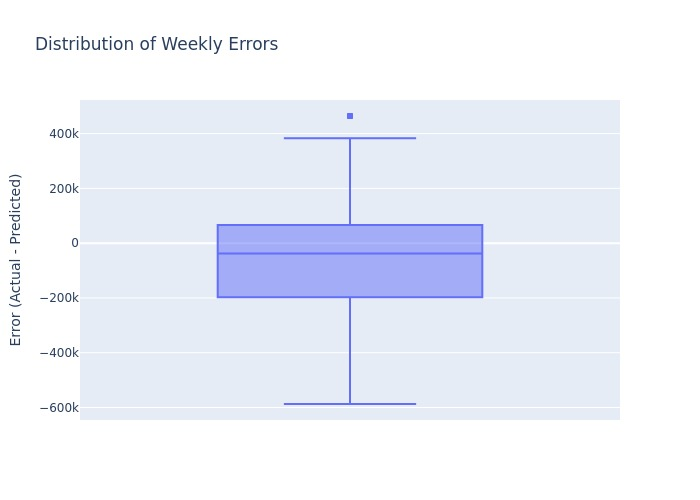

In [43]:
fig_box = px.box(
    df_weekly,
    y="Error",
    title="Distribution of Weekly Errors",
)
fig_box.update_layout(yaxis_title="Error (Actual - Predicted)")

pio.show(fig_box)

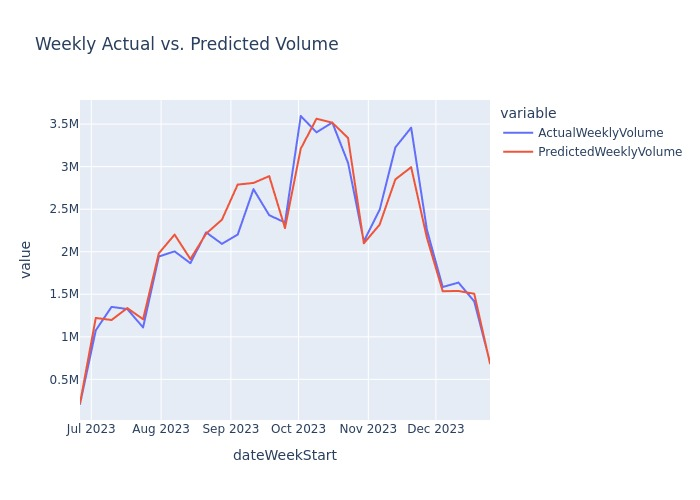

In [44]:
fig = px.line(
    df_weekly,
    x="dateWeekStart",
    y=["ActualWeeklyVolume", "PredictedWeeklyVolume"],
    title="Weekly Actual vs. Predicted Volume",
)
pio.show(fig)

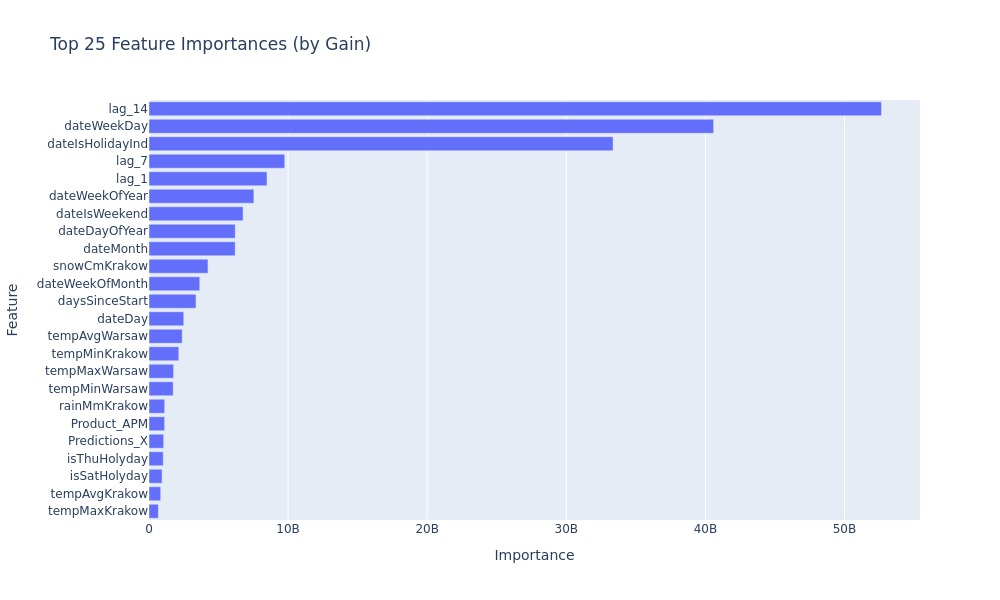

In [45]:
importance_dict = model.get_booster().get_score(importance_type="gain")

sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

top_n = 25
top_features = sorted_importance[:top_n]

df_imp = pd.DataFrame(top_features, columns=["Feature", "Importance"])

fig_feat = px.bar(
    df_imp,
    width=1000,
    height=600,
    x="Importance",
    y="Feature",
    orientation="h",
    title=f"Top {top_n} Feature Importances (by Gain)",
)

fig_feat.update_yaxes(autorange="reversed")
fig_feat.update_layout(xaxis_title="Importance", yaxis_title="Feature")
pio.show(fig_feat)

In [46]:
importance_dict = model.get_booster().get_score(importance_type="gain")
print(importance_dict)

{'Product_APM': 1123406208.0, 'dateMonth': 6195805696.0, 'dateDay': 2499870208.0, 'dateWeekDay': 40590999552.0, 'dateDayOfYear': 6198316544.0, 'dateWeekOfMonth': 3650865664.0, 'dateWeekOfYear': 7540961280.0, 'dateIsWeekend': 6763737088.0, 'dateIsHolidayInd': 33363068928.0, 'isThuHolyday': 1024036224.0, 'isSatHolyday': 941286784.0, 'Predictions_X': 1054563712.0, 'tempMaxKrakow': 673768768.0, 'tempMaxWarsaw': 1768820992.0, 'tempMinKrakow': 2141550720.0, 'tempMinWarsaw': 1739832832.0, 'tempAvgKrakow': 842014720.0, 'tempAvgWarsaw': 2388980992.0, 'rainMmKrakow': 1127099136.0, 'snowCmKrakow': 4240198144.0, 'daysSinceStart': 3376553472.0, 'lag_1': 8482155008.0, 'lag_7': 9758778368.0, 'lag_14': 52657098752.0}


In [49]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

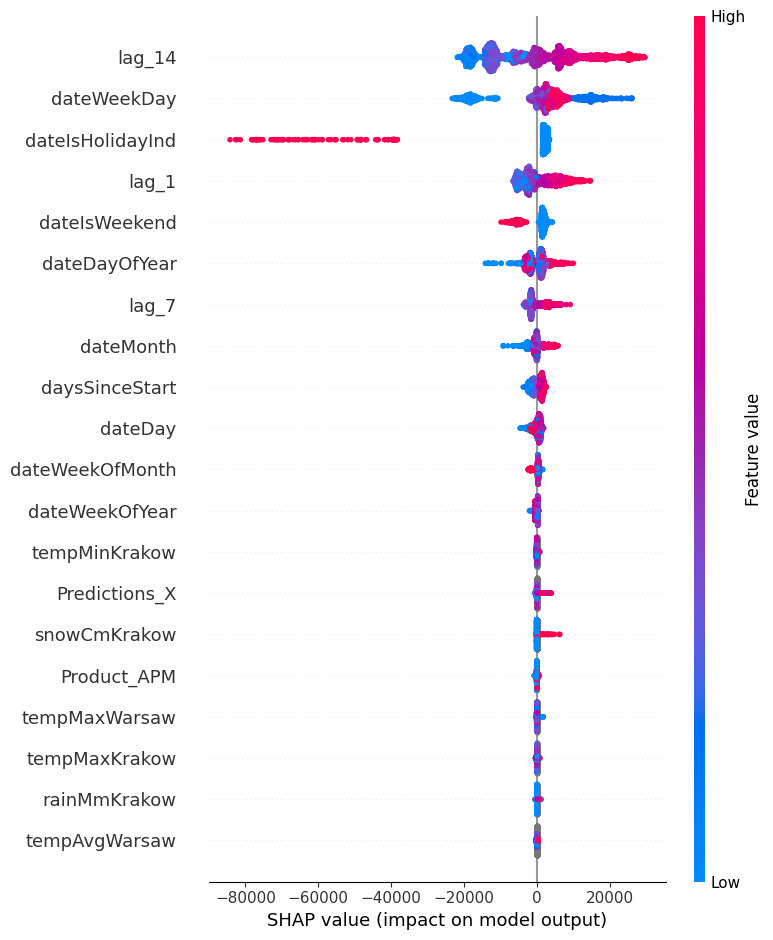

In [50]:
shap.summary_plot(shap_values, X_train)

# Propozycje usprawnień

- Uwzględnienie danych o okresach szczególnego natężenia wysyłania paczek - black friday/ okres przedswiąteczny
- Być może dodanie dodatkowych zmiennych określających bliskość świąt/ przerw w dostawach
- Dodatkowe interakcje między cechami (np. klient x produkt)
- Dodatkowe informacje o regionie wysyłki - być może dane o pogodzie byłyby wówczas bardziej istotne 
- Zwiększenie liczby dat granicznych np. uwzględnienie też dat na początku i środku miesiąca
- Dodanie przedziałów ufności do prognoz
- Być może uzasadnione byłaby kategoryzacja klientów innych niż X na podgrupy ze względu na ilość przesyłek
- Połączenie XGBoost z klasycznym modelem SARIMA mogłoby potencjalnie poprawić działanie modelu